# CONFIGS

In [ ]:
BATCH_SIZE = 4
CHANNEL_IMG = 3             # RGB
LEARNING_RATE = 1e-3
IMAGE_SIZE = 1024
Z_DIM = 256
IN_CHANNEL = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = "celeba_hq/train"

EPOCHES_PER_BLOCK = [1]*9 # [10]*9


# Paper: Progressive Growing of GANs for Improved Quality, Stability, and Variation
    https://arxiv.org/pdf/1710.10196.pdf

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
factors = [1,1,1,1,1/2,1/4,1/8,1/16,1/32]

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel=3, stride=1, padding=1, gain=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel, stride, padding)
        self.scale_factor = (gain/(in_channel* kernel**2))**0.5 # That He initlisation thing

        # bias will not be scaled
        self.bias = self.conv.bias
        self.conv.bias = None

        # implement He init - for equalised learning rate
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale_factor) + self.bias.view(1, self.bias.shape[0], 1, 1)


In [ ]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x/torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [ ]:
class Blocks(nn.Module):
    def __init__(self, in_channel, out_channel, use_pixelNorm=True):
        super().__init__()
        self.conv1 = Conv2d(in_channel, out_channel)
        self.conv2 = Conv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2)
        self.pxlNrm = PixelNorm()
        self.usePxlNrm = use_pixelNorm

    def forward(self, x):
        x = self.leaky( self.conv1(x) )
        x = self.pxlNrm( x ) if self.usePxlNrm else x

        x = self.leaky( self.conv2(x) )
        x = self.pxlNrm( x ) if self.usePxlNrm else x
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channel, img_channel=3):
        super().__init__()
        self.initialBlock = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channel, 4, 1, 0), # 1x1 -> 4x4
            nn.LeakyReLU(0.2),
            Conv2d(in_channel, in_channel, kernel=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm()
        )
        self.initial_toRGB = Conv2d(in_channel, img_channel, kernel=1, stride=1, padding=0)

        self.pro_blocks, self.to_rgbRGB_layers = nn.ModuleList(), nn.ModuleList( [self.initial_toRGB] )

        for i in range(len(factors) - 1):
            conv_in_channel = int(in_channel * factors[i])
            conv_out_channel = int(in_channel * factors[i+1])

            self.pro_blocks.append(Blocks(conv_in_channel, conv_out_channel))
            self.to_rgbRGB_layers.append(Conv2d(conv_out_channel, img_channel, kernel=1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha*generated + (1-alpha)*upscaled)

    def forward(self, x, alpha, steps): # steps=0 -> 4x4 ; steps=1 -> 8x8
        out = self.initialBlock(x)
        if steps == 0:
            return self.initial_toRGB(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.pro_blocks[step](upscaled)

        final_upscaled = self.to_rgbRGB_layers[steps-1](upscaled)
        final_out = self.to_rgbRGB_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channel, img_channel=3):
        super().__init__()
        self.pro_blocks, self.to_RGB_layers = nn.ModuleList(), nn.ModuleList()
        self.leaky = nn.LeakyReLU(0.2)

        for i in range(len(factors) - 1, 0, -1):
            conv_in_channel = int(in_channel * factors[i])
            conv_out_channel = int(in_channel * factors[i-1])

            self.pro_blocks.append(Blocks(conv_in_channel, conv_out_channel, use_pixelNorm=False))
            self.to_RGB_layers.append(Conv2d(img_channel, conv_in_channel, kernel=1, stride=1, padding=0))

        self.initial_toRGB = Conv2d(img_channel, in_channel, kernel=1, stride=1, padding=0)
        self.to_RGB_layers.append(self.initial_toRGB)
        self.downsample = nn.AvgPool2d(kernel_size=2, stride=2)

        self.final_block = nn.Sequential(
            Conv2d(in_channel+1, in_channel, kernel=3, stride=1, padding=1), # mini batch std
            nn.LeakyReLU(0.2),
            Conv2d(in_channel, in_channel, kernel=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            Conv2d(in_channel, 1, kernel=1, padding=0, stride=1)
        )

    def fade_in(self, alpha, downscaled, out):
        return alpha*out + (1-alpha)*downscaled

    def miniBatch_std(self, x):
        batch_stat = torch.std(x, dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3])
        return torch.cat([x, batch_stat], dim=1)

    def forward(self, x, alpha, steps):
        curr_step = len(self.pro_blocks) - steps
        out = self.leaky( self.to_RGB_layers[curr_step](x))

        if steps == 0:
            out = self.miniBatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        downscaled = self.leaky( self.to_RGB_layers[curr_step + 1](self.downsample(x)) )
        out = self.downsample(self.pro_blocks[curr_step](out))

        for step in range(curr_step+1, len(self.pro_blocks)):
            out = self.pro_blocks[step](out)
            out = self.downsample(out)

        out = self.miniBatch_std(out)
        return self.final_block(out).view(out.shape[0],-1)

# Setup Initial Test

In [ ]:
Z_DIM = 50
IN_CHANNEL = 256
gen = Generator(Z_DIM, IN_CHANNEL, img_channel=3)
critic = Discriminator(Z_DIM, IN_CHANNEL, img_channel=3)

for img_size in [4,8,16,32,64,128,256,512,1024]:
    num_steps = int(log2(img_size/4))
    # print(num_steps, img_size, log2(img_size)/4)
    x = torch.randn((1,Z_DIM,1,1))

    z = gen(x, 0.5, num_steps)
    assert z.shape == (1,3, img_size, img_size)

    out = critic(z, alpha=0.5, steps=num_steps)
    assert out.shape == (1,1)

    print(f"Success! At img size : {img_size}")


Success! At img size : 4
Success! At img size : 8
Success! At img size : 16
Success! At img size : 32
Success! At img size : 64
Success! At img size : 128
Success! At img size : 256
Success! At img size : 512
Success! At img size : 1024


# Train Setup

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d lamsimon/celebahq

100% 2.55G/2.55G [02:04<00:00, 24.9MB/s]
100% 2.55G/2.55G [02:04<00:00, 22.0MB/s]


In [ ]:
! unzip celebahq.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba_hq/train/male/140695.jpg  
  inflating: celeba_hq/train/male/140721.jpg  
  inflating: celeba_hq/train/male/140741.jpg  
  inflating: celeba_hq/train/male/140761.jpg  
  inflating: celeba_hq/train/male/140768.jpg  
  inflating: celeba_hq/train/male/140777.jpg  
  inflating: celeba_hq/train/male/140787.jpg  
  inflating: celeba_hq/train/male/140792.jpg  
  inflating: celeba_hq/train/male/140798.jpg  
  inflating: celeba_hq/train/male/140823.jpg  
  inflating: celeba_hq/train/male/140846.jpg  
  inflating: celeba_hq/train/male/140857.jpg  
  inflating: celeba_hq/train/male/140889.jpg  
  inflating: celeba_hq/train/male/140938.jpg  
  inflating: celeba_hq/train/male/140951.jpg  
  inflating: celeba_hq/train/male/140963.jpg  
  inflating: celeba_hq/train/male/140980.jpg  
  inflating: celeba_hq/train/male/141029.jpg  
  inflating: celeba_hq/train/male/141052.jpg  
  inflating: celeba_hq/train/male/141061.jpg  
  inflati

In [ ]:
def get_loader(image_size):
    transform = T.Compose(
        [
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.RandomHorizontalFlip(p=0.5),
            T.Normalize(
                [0.5 for _ in range(CHANNEL_IMG)],
                [0.5 for _ in range(CHANNEL_IMG)]
            )
        ]
    )
    dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )
    return loader, dataset

In [ ]:
def train_an_epoch(critic,gen,loader,opt_gen,opt_critic,dataset,alpha, step):
    loop = tqdm(loader, leave=True)
    noise_plot = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)

        # ========================== CRITIC ==============================
        # max (E[critic(real)] - E[critic(fake)])
        # OR
        # min -(E[critic(real)] - E[critic(fake)])

        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)
        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step) # detached cuz do not train gen -> fake comes out of gen

        loss_critic = (
            -(torch.mean(critic_real)-torch.mean(critic_fake))
            + (0.001 * torch.mean(critic_real ** 2)) # Drift mentioned in paper
            # Gradient Penalty is not implemented
        )
        opt_critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # ============================ GEN ===========================
        fake = gen(noise, alpha, step)
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx%50 == 0:

          fake = gen(noise_plot, alpha, step)  # step=0 ; so 1st layer 4x4
          fake = fake.permute(0,2,3,1).cpu().detach().squeeze().numpy()
          print(fake.shape)

          plt.imshow(fake)
          plt.show()

        alpha += BATCH_SIZE/(len(dataset))
        alpha = min(alpha, 1)

    return alpha


# DRIVER

In [ ]:
gen = Generator(Z_DIM, IN_CHANNEL, img_channel=CHANNEL_IMG).to(DEVICE)
critic = Discriminator(Z_DIM, IN_CHANNEL, img_channel=CHANNEL_IMG).to(DEVICE)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0,0.99))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0,0.99))

gen.train()
critic.train()

step = 0
for num_epochs in EPOCHES_PER_BLOCK:
    alpha = 1e-5
    loader, dataset = get_loader(4*2**step)
    print(f"Image Size : {4*2**step}")

    train_an_epoch(critic, gen, loader, opt_gen, opt_critic, dataset, alpha, step)

    step += 1


RuntimeError: ignored

(4, 4, 3)


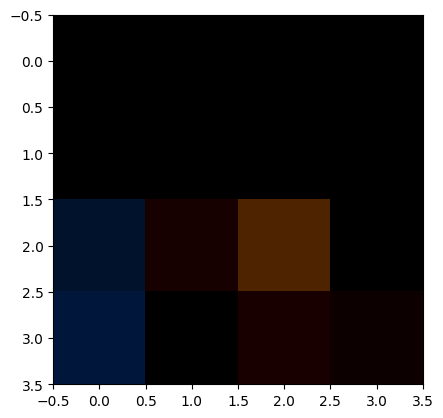

In [ ]:
noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
fake = gen(noise, alpha, 0)  # step=0 ; so 1st layer 4x4
fake = fake.permute(0,2,3,1).cpu().detach().squeeze().numpy()
print(fake.shape)

plt.imshow(fake)
plt.show()

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()